# Redes GAN - Dataset MNIST

Projeto - Pós Graduação IESB

Disciplina - Aprendizagem Supervizsionada

Professora: Tatiana Tavares


GRUPO:

Rafael Lino

Ricardo Malta

Thiago Cesar


Introdução: Redes GAN - Dataset MNIST: 

	Neste trabalho abordaremos uma rede neural (ou o conjunto de duas redes) chamada Generative Adversarial Network (GAN) utilizando o Dataset MNIST, que pode ser baixado por meio da biblioteca tensorflow. 
    As redes GAN funcionam por meio de uma rede Generativa e uma Discriminativa, que "competem" entre si. Sendo que, baseado em uma amostra de imagens, a rede generativa começa a gerar novas imagens cada vez mais parecidas com as originais. A rede discriminativa, por sua vez, recebe aleatoriamente imagens reais e falsas e trabalha para distinguir umas das outras.
    
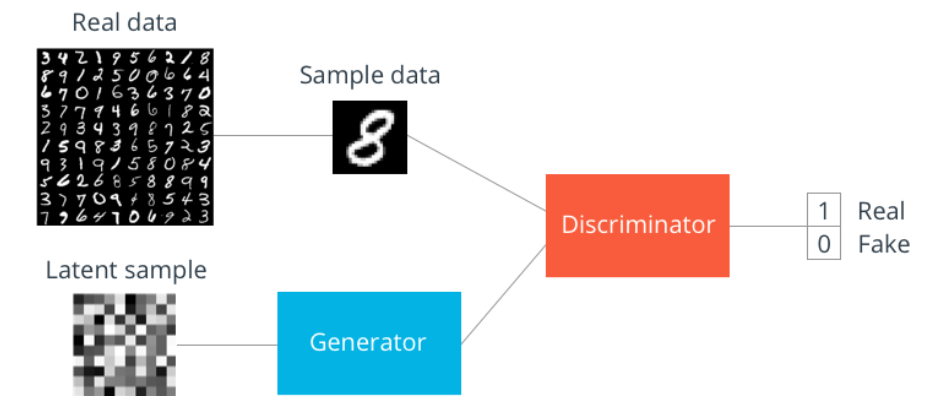

In [152]:
import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

Abaixo faremos o download da base direto dos exemplos importados pelo tensorflow

In [153]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [154]:
mnist.validation.images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Para o avanço criamos os modelos de input usados no discriminador (real) e do gerador (z)

In [155]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name="inputs_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="inputs_z")
    
    return inputs_real, inputs_z

O tensorflow não possui operação de Leacky ReLU, para isso basta inserir as saídas da camada linear no tf.maximun. 
A variável "reuse" é utilizada para que o tensorflow reutilize as variáveis e não crie novas e assim o discriminador pode compartilhar dessas variáveis entre imagens falsas e reais.

In [156]:
def generator(z, out_dim, n_units=128, reuse=False,  alpha=0.01):
    with tf.variable_scope('generator', reuse=reuse):

        h1 = tf.layers.dense(z, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(h1, alpha*h1)
        
        # Logits and tanh output
        logits = tf.layers.dense(h1, out_dim, activation=None)
        out = tf.nn.tanh(logits)
        
        return out, logits

A rede discriminadora é similar à geradora, sendo diferente apenas pela camada de saída sendo uma sigmóide.

In [157]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):

        h1 = tf.layers.dense(x, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(h1, alpha*h1)
        
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.nn.sigmoid(logits)
        
        return out, logits

Normalização das imagens e construção das dos inputs das redes

In [158]:
input_size = 784 # 28x28
z_size = 100
g_hidden_size = 128
d_hidden_size = 128
alpha = 0.01
smooth = 0.1

In [159]:
tf.reset_default_graph()
input_real, input_z = model_inputs(input_size, z_size)

g_model, g_logits = generator(input_z, input_size, g_hidden_size, reuse=False,  alpha=alpha)

d_model_real, d_logits_real = discriminator(input_real, d_hidden_size, reuse=False, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, d_hidden_size, reuse=True, alpha=alpha)

Para o cálculo de perdas, as labels reais são submetidos a uma suavização de rótulos e reduzidos com objetivo de melhora de desempenho, por meio do smooth.  Já os labels fake são usados como rótulo dos resultados 0 (o discriminador classificará como 0 falso e 1 real).

In [160]:
d_labels_real = tf.ones_like(d_logits_real) * (1 - smooth)
d_labels_fake = tf.zeros_like(d_logits_fake)

d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_labels_real, logits=d_logits_real)
d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_labels_fake, logits=d_logits_fake)

d_loss = tf.reduce_mean(d_loss_real + d_loss_fake)

g_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.ones_like(d_logits_fake), 
        logits=d_logits_fake))

Otimizador de código

In [161]:
# Otimizador
learning_rate = 0.002

t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith("generator")]
d_vars = [var for var in t_vars if var.name.startswith("discriminator")]

d_train_opt = tf.train.AdamOptimizer().minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer().minimize(g_loss, var_list=g_vars)

# Treinamento

Para o treinamento serão treinadas 100 épocas. Sendo que as imagens são normalizadas, geradas com ruído pelo gerador e submetidas à classificação do discriminador. Há a possibilidade de salvar os arquivos de treinamento e a cada época as imagens geradas são mostradas de forma original e em escala de cinza.

Epoch 1/100... Discriminator Loss: 0.3477... Generator Loss: 4.1753


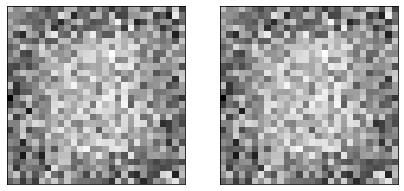

Epoch 2/100... Discriminator Loss: 0.3989... Generator Loss: 3.4739


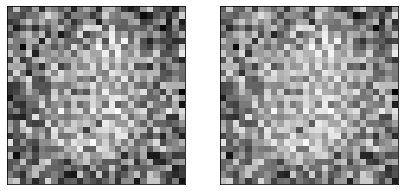

Epoch 3/100... Discriminator Loss: 0.3656... Generator Loss: 4.0953


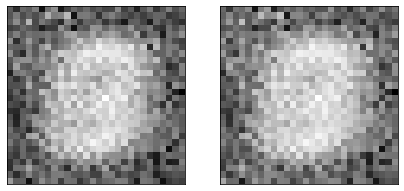

Epoch 4/100... Discriminator Loss: 0.3998... Generator Loss: 3.2786


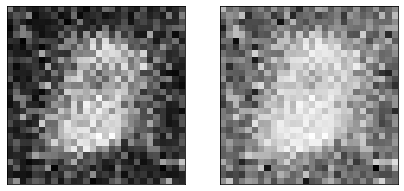

Epoch 5/100... Discriminator Loss: 0.5445... Generator Loss: 2.9101


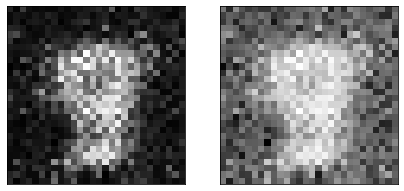

Epoch 6/100... Discriminator Loss: 0.5272... Generator Loss: 4.4804


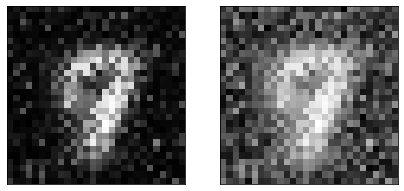

Epoch 7/100... Discriminator Loss: 0.7483... Generator Loss: 4.4709


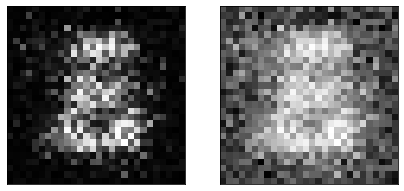

Epoch 8/100... Discriminator Loss: 0.5108... Generator Loss: 4.1195


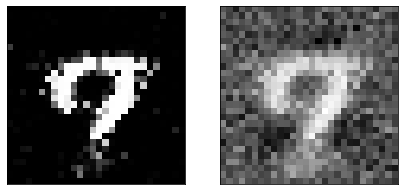

Epoch 9/100... Discriminator Loss: 0.5797... Generator Loss: 3.9476


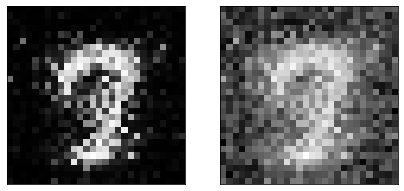

Epoch 10/100... Discriminator Loss: 0.9374... Generator Loss: 2.3409


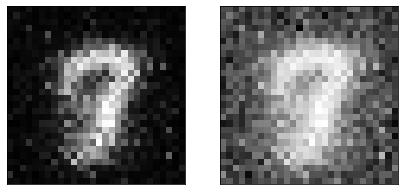

Epoch 11/100... Discriminator Loss: 0.6620... Generator Loss: 5.1262


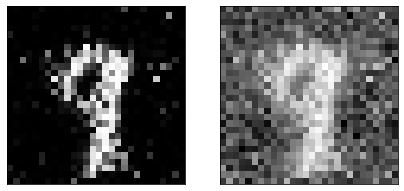

Epoch 12/100... Discriminator Loss: 0.6722... Generator Loss: 4.2618


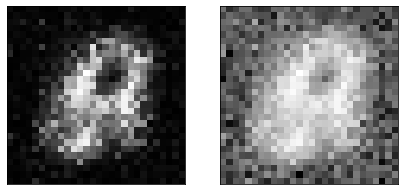

Epoch 13/100... Discriminator Loss: 0.8689... Generator Loss: 3.9521


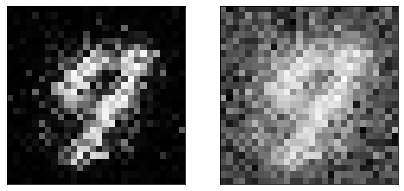

Epoch 14/100... Discriminator Loss: 1.5664... Generator Loss: 2.0073


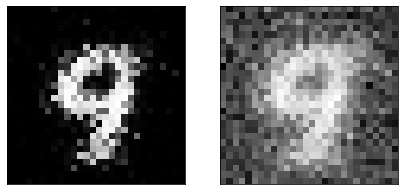

Epoch 15/100... Discriminator Loss: 0.9666... Generator Loss: 2.7374


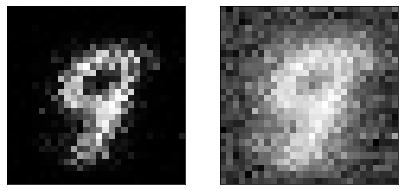

Epoch 16/100... Discriminator Loss: 1.2250... Generator Loss: 3.3516


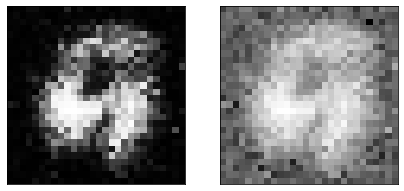

Epoch 17/100... Discriminator Loss: 0.7597... Generator Loss: 4.1019


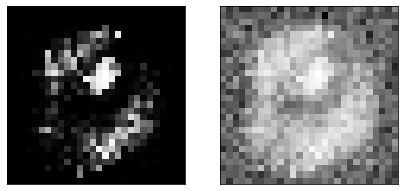

Epoch 18/100... Discriminator Loss: 1.5465... Generator Loss: 1.6191


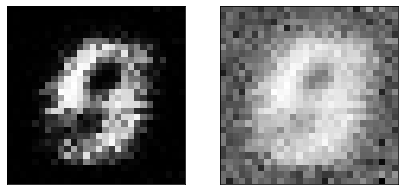

Epoch 19/100... Discriminator Loss: 0.9371... Generator Loss: 2.2487


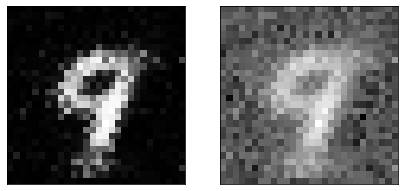

Epoch 20/100... Discriminator Loss: 1.2921... Generator Loss: 1.5001


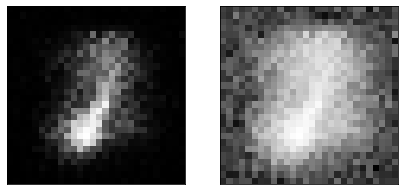

Epoch 21/100... Discriminator Loss: 1.0407... Generator Loss: 1.6381


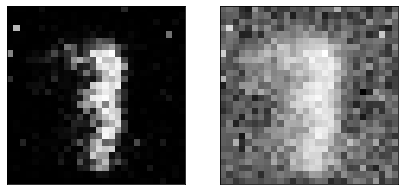

Epoch 22/100... Discriminator Loss: 1.3370... Generator Loss: 1.4652


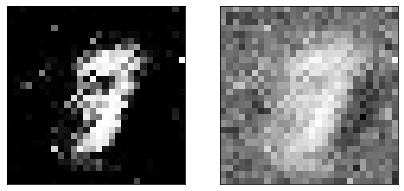

Epoch 23/100... Discriminator Loss: 1.1726... Generator Loss: 1.7975


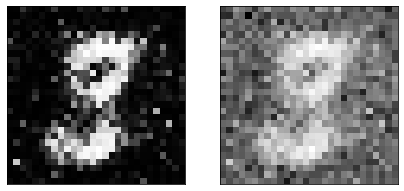

Epoch 24/100... Discriminator Loss: 0.9737... Generator Loss: 1.7550


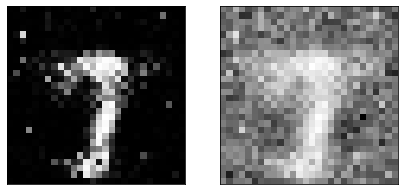

Epoch 25/100... Discriminator Loss: 1.0457... Generator Loss: 1.9132


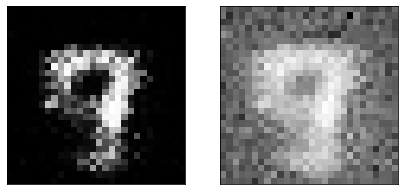

Epoch 26/100... Discriminator Loss: 0.9487... Generator Loss: 2.7017


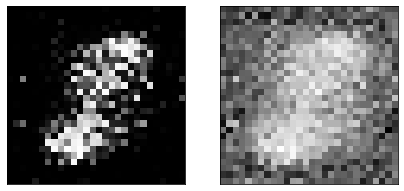

Epoch 27/100... Discriminator Loss: 0.9443... Generator Loss: 1.7744


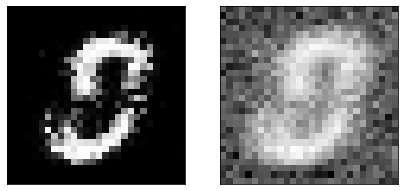

Epoch 28/100... Discriminator Loss: 0.7383... Generator Loss: 2.3798


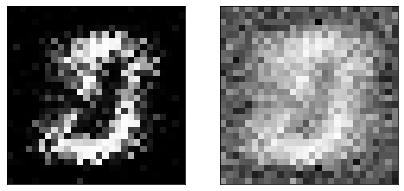

Epoch 29/100... Discriminator Loss: 0.9513... Generator Loss: 1.7930


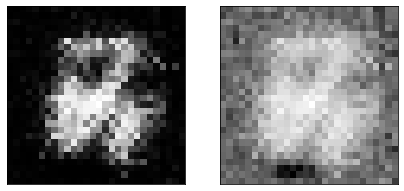

Epoch 30/100... Discriminator Loss: 1.6238... Generator Loss: 1.1325


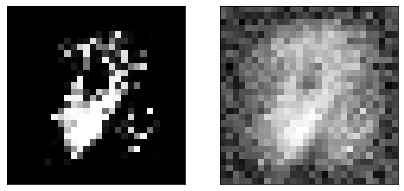

Epoch 31/100... Discriminator Loss: 0.9657... Generator Loss: 1.7701


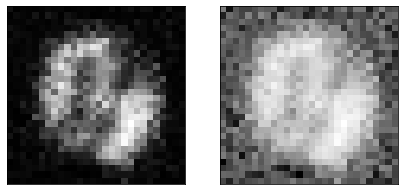

Epoch 32/100... Discriminator Loss: 1.1893... Generator Loss: 1.3845


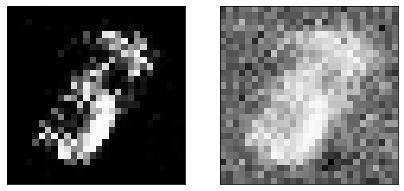

Epoch 33/100... Discriminator Loss: 0.7479... Generator Loss: 2.4181


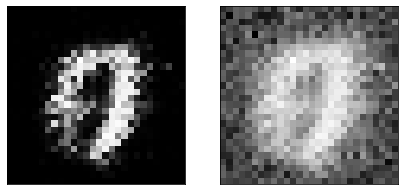

Epoch 34/100... Discriminator Loss: 1.0616... Generator Loss: 1.7661


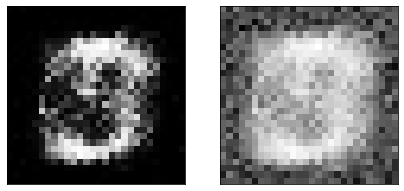

Epoch 35/100... Discriminator Loss: 1.3036... Generator Loss: 1.7821


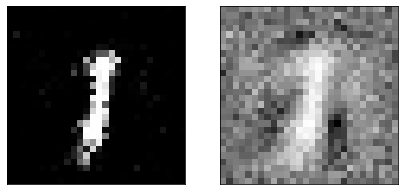

Epoch 36/100... Discriminator Loss: 1.4761... Generator Loss: 1.6360


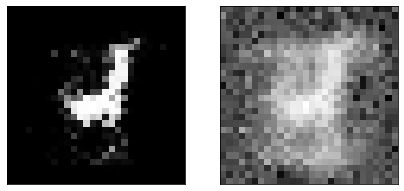

Epoch 37/100... Discriminator Loss: 1.1040... Generator Loss: 1.3120


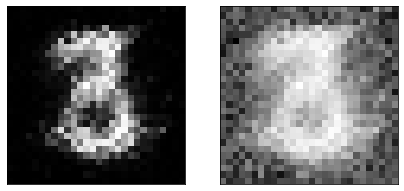

Epoch 38/100... Discriminator Loss: 1.4308... Generator Loss: 1.6946


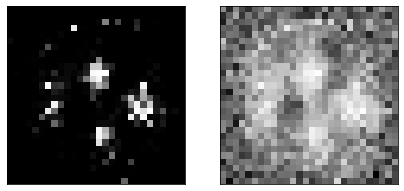

Epoch 39/100... Discriminator Loss: 0.9689... Generator Loss: 1.5444


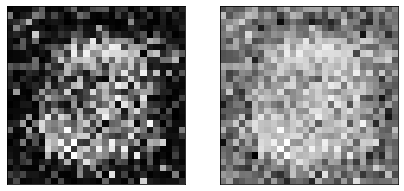

Epoch 40/100... Discriminator Loss: 1.2289... Generator Loss: 1.9224


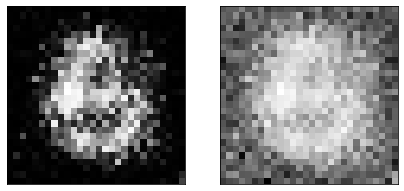

Epoch 41/100... Discriminator Loss: 1.0807... Generator Loss: 1.6336


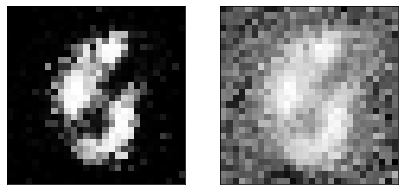

Epoch 42/100... Discriminator Loss: 0.9329... Generator Loss: 1.8440


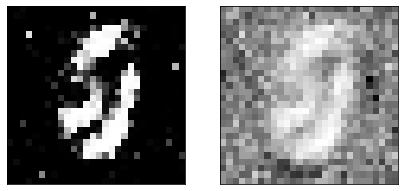

Epoch 43/100... Discriminator Loss: 0.9382... Generator Loss: 1.8080


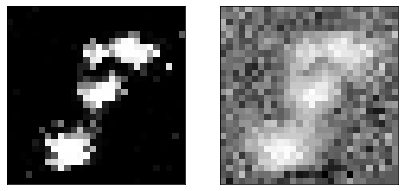

Epoch 44/100... Discriminator Loss: 1.1024... Generator Loss: 1.6618


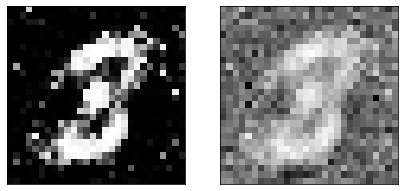

Epoch 45/100... Discriminator Loss: 0.9754... Generator Loss: 1.7447


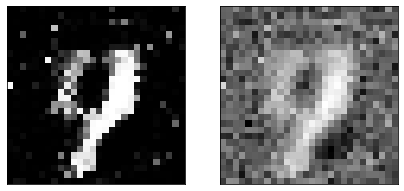

Epoch 46/100... Discriminator Loss: 0.9719... Generator Loss: 1.4998


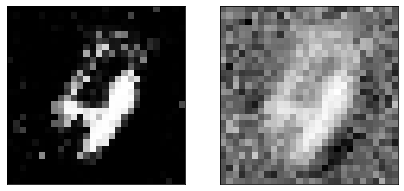

Epoch 47/100... Discriminator Loss: 0.9688... Generator Loss: 1.9444


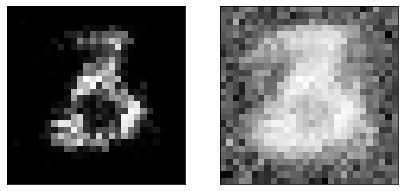

Epoch 48/100... Discriminator Loss: 1.0857... Generator Loss: 1.4461


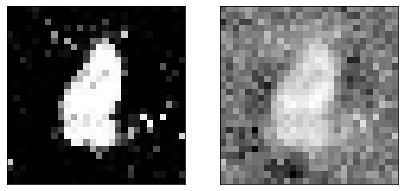

Epoch 49/100... Discriminator Loss: 1.0015... Generator Loss: 1.6643


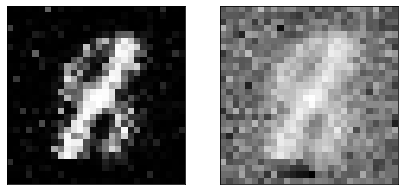

Epoch 50/100... Discriminator Loss: 0.7755... Generator Loss: 1.7617


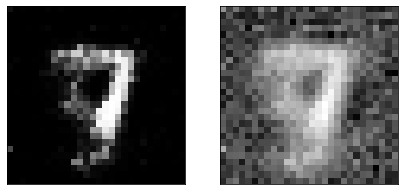

Epoch 51/100... Discriminator Loss: 1.1468... Generator Loss: 1.4636


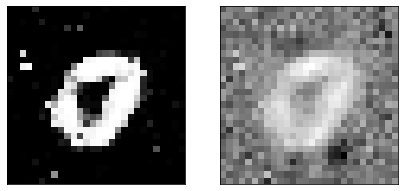

Epoch 52/100... Discriminator Loss: 0.8454... Generator Loss: 1.7981


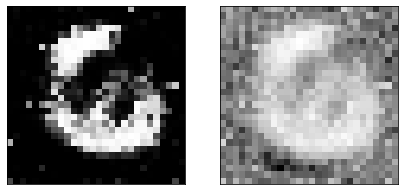

Epoch 53/100... Discriminator Loss: 1.0024... Generator Loss: 1.7079


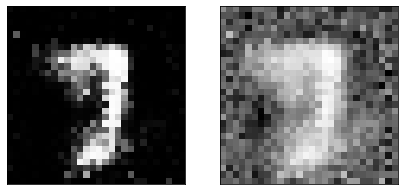

Epoch 54/100... Discriminator Loss: 1.0899... Generator Loss: 1.6986


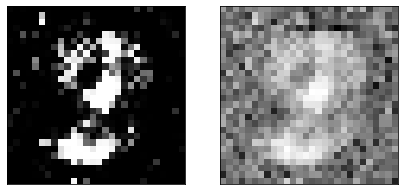

Epoch 55/100... Discriminator Loss: 1.3032... Generator Loss: 1.2226


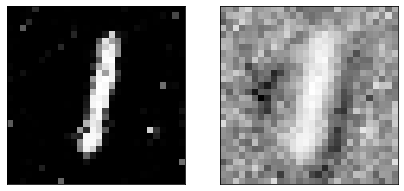

Epoch 56/100... Discriminator Loss: 1.0176... Generator Loss: 1.5290


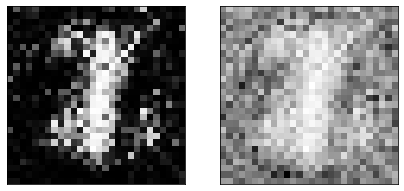

Epoch 57/100... Discriminator Loss: 1.1678... Generator Loss: 1.4736


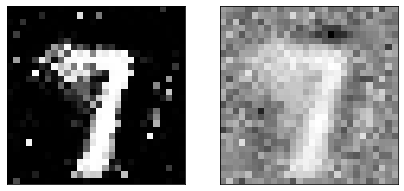

Epoch 58/100... Discriminator Loss: 0.9608... Generator Loss: 1.6384


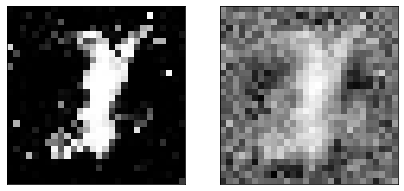

Epoch 59/100... Discriminator Loss: 0.7644... Generator Loss: 1.8406


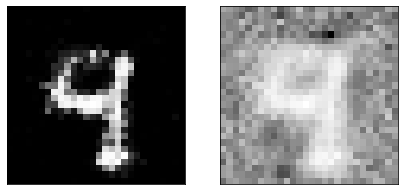

Epoch 60/100... Discriminator Loss: 0.9055... Generator Loss: 1.8399


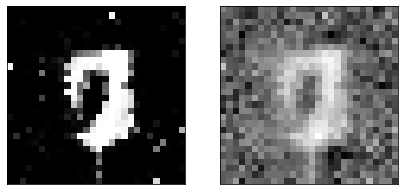

Epoch 61/100... Discriminator Loss: 1.0471... Generator Loss: 1.6706


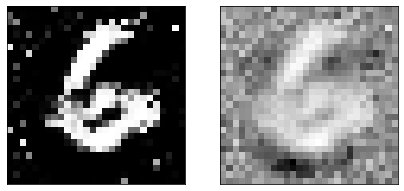

Epoch 62/100... Discriminator Loss: 1.3247... Generator Loss: 1.1925


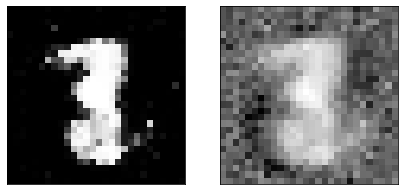

Epoch 63/100... Discriminator Loss: 0.8484... Generator Loss: 1.7780


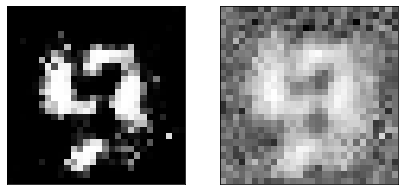

Epoch 64/100... Discriminator Loss: 1.1252... Generator Loss: 1.5195


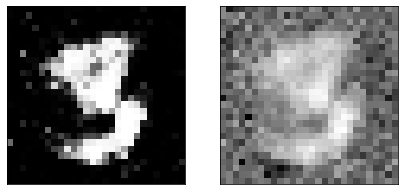

Epoch 65/100... Discriminator Loss: 1.0674... Generator Loss: 1.4706


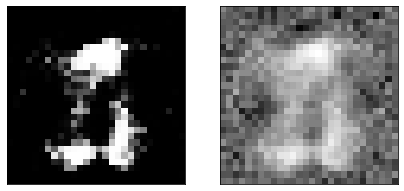

Epoch 66/100... Discriminator Loss: 1.3861... Generator Loss: 1.3163


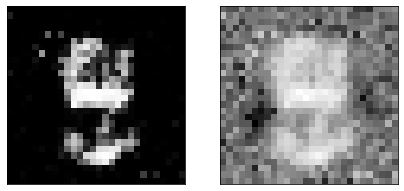

Epoch 67/100... Discriminator Loss: 1.0074... Generator Loss: 1.7498


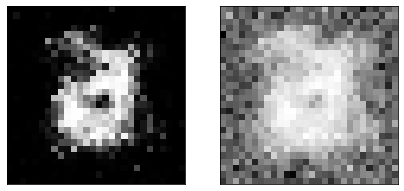

Epoch 68/100... Discriminator Loss: 1.0640... Generator Loss: 1.4344


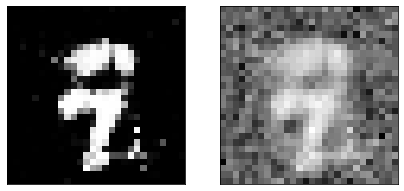

Epoch 69/100... Discriminator Loss: 1.2218... Generator Loss: 1.4346


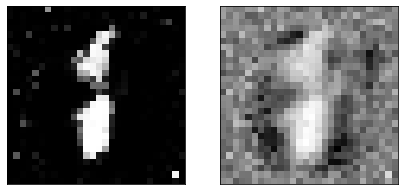

Epoch 70/100... Discriminator Loss: 1.1057... Generator Loss: 1.6969


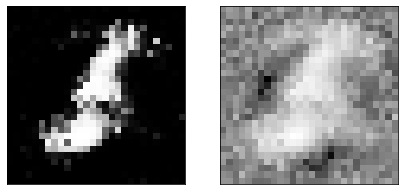

Epoch 71/100... Discriminator Loss: 1.4900... Generator Loss: 0.9576


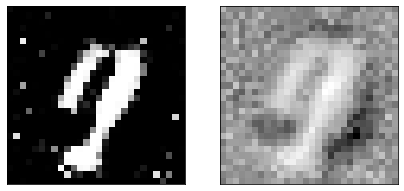

Epoch 72/100... Discriminator Loss: 1.1331... Generator Loss: 1.2468


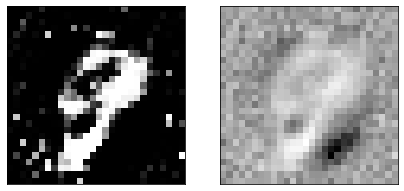

Epoch 73/100... Discriminator Loss: 1.0263... Generator Loss: 1.5497


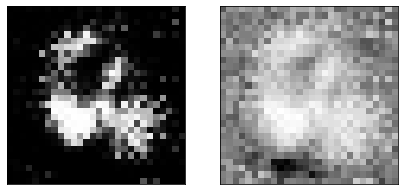

Epoch 74/100... Discriminator Loss: 1.0142... Generator Loss: 1.6316


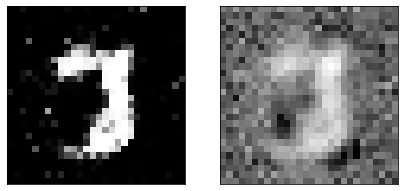

Epoch 75/100... Discriminator Loss: 1.0292... Generator Loss: 1.6367


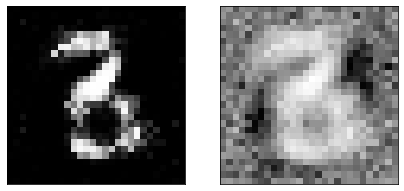

Epoch 76/100... Discriminator Loss: 0.8451... Generator Loss: 1.9882


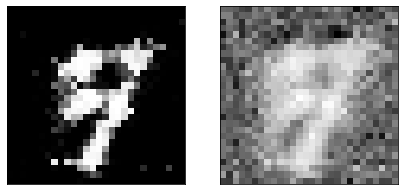

Epoch 77/100... Discriminator Loss: 1.1662... Generator Loss: 1.4970


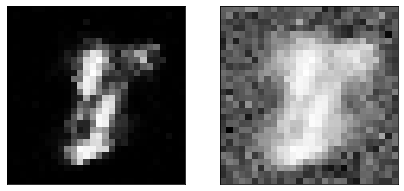

Epoch 78/100... Discriminator Loss: 1.0242... Generator Loss: 1.5003


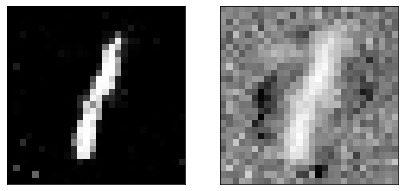

Epoch 79/100... Discriminator Loss: 0.9898... Generator Loss: 1.8460


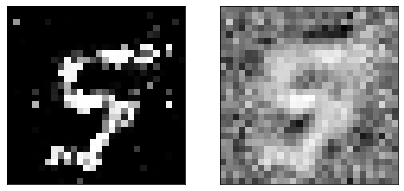

Epoch 80/100... Discriminator Loss: 0.9782... Generator Loss: 1.7257


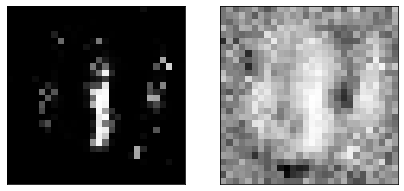

Epoch 81/100... Discriminator Loss: 0.9767... Generator Loss: 1.7966


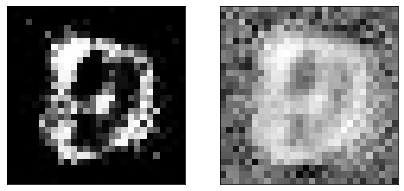

Epoch 82/100... Discriminator Loss: 0.8922... Generator Loss: 1.5897


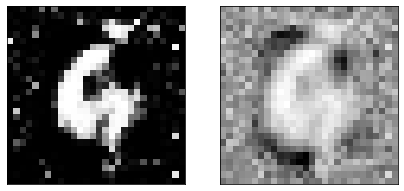

Epoch 83/100... Discriminator Loss: 1.0572... Generator Loss: 1.4086


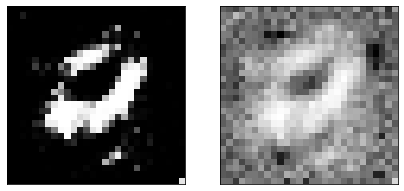

Epoch 84/100... Discriminator Loss: 1.0944... Generator Loss: 1.6555


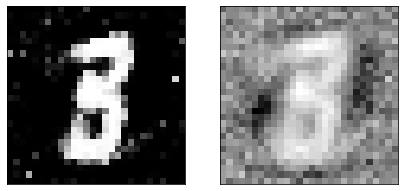

Epoch 85/100... Discriminator Loss: 0.7962... Generator Loss: 2.2408


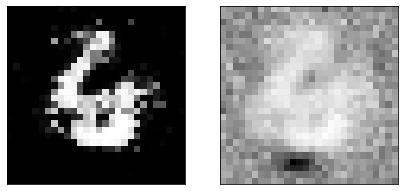

Epoch 86/100... Discriminator Loss: 1.2140... Generator Loss: 1.6754


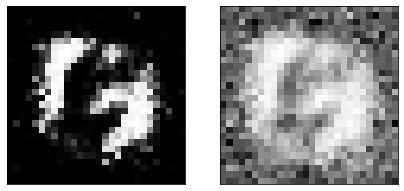

Epoch 87/100... Discriminator Loss: 1.2125... Generator Loss: 1.6195


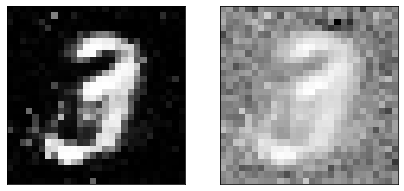

Epoch 88/100... Discriminator Loss: 0.9674... Generator Loss: 1.8143


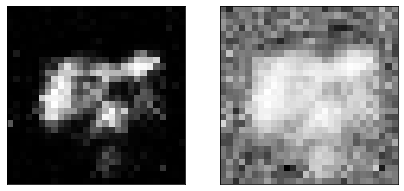

Epoch 89/100... Discriminator Loss: 0.9213... Generator Loss: 1.7032


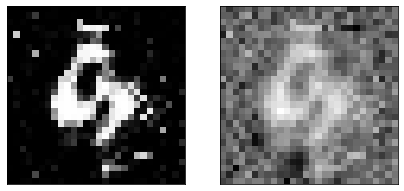

Epoch 90/100... Discriminator Loss: 0.8074... Generator Loss: 2.0204


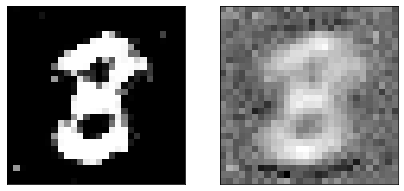

Epoch 91/100... Discriminator Loss: 1.0195... Generator Loss: 1.7500


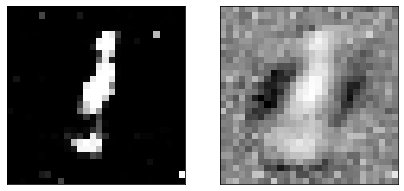

Epoch 92/100... Discriminator Loss: 1.1029... Generator Loss: 1.4228


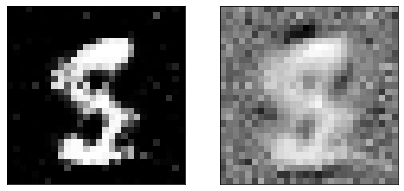

Epoch 93/100... Discriminator Loss: 1.0078... Generator Loss: 1.6101


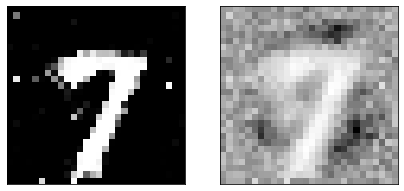

Epoch 94/100... Discriminator Loss: 1.0400... Generator Loss: 1.4758


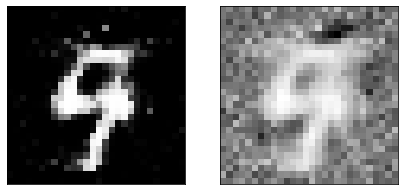

Epoch 95/100... Discriminator Loss: 1.0404... Generator Loss: 1.7880


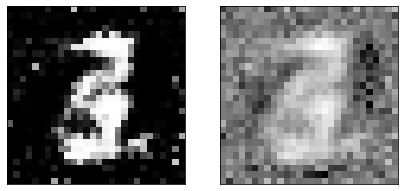

Epoch 96/100... Discriminator Loss: 1.0438... Generator Loss: 1.7135


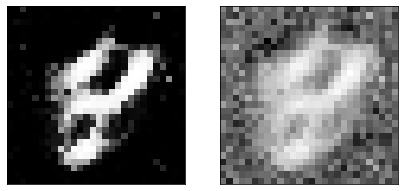

Epoch 97/100... Discriminator Loss: 1.3377... Generator Loss: 1.5080


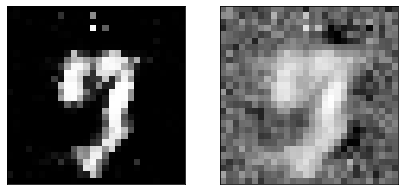

Epoch 98/100... Discriminator Loss: 1.1224... Generator Loss: 1.7261


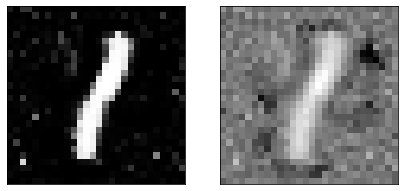

Epoch 99/100... Discriminator Loss: 0.8653... Generator Loss: 1.9054


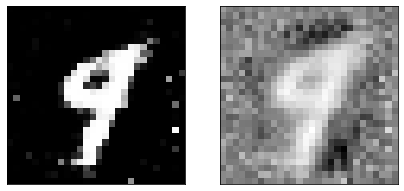

Epoch 100/100... Discriminator Loss: 1.0506... Generator Loss: 1.6520


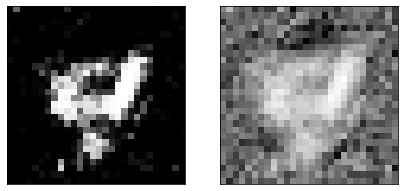

In [162]:
batch_size = 100
epochs = 100
samples = []
losses = []
saver = tf.train.Saver(var_list = g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            # Normaliza a imagem para transferir para o discriminador
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Exemplo aleatório com ruído - gerador
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        # Perdas por época
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))   
        losses.append((train_loss_d, train_loss_g))
        
        sample_z = np.random.uniform(-1, 1, size=(1, z_size))
        gen_samples = sess.run(
                       generator(input_z, input_size, reuse=True),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        
        # Printa imagens geradas 
        fig, axes = plt.subplots(figsize=(7,7), nrows=1, ncols=2, sharey=True, sharex=True)
        for ax, img in zip(axes.flatten(),samples[e]):
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            #img = np.arange(12544).reshape(56,224)
            im = ax.imshow(img.reshape(28,28), cmap='Greys_r')
            
        saver.save(sess, './checkpoints/generator.ckpt')
        plt.show()
        
with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)

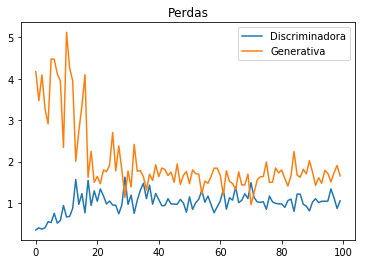

In [165]:
# Gáfico de perdas
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminadora')
plt.plot(losses.T[1], label='Generativa')
plt.title("Perdas")
plt.legend()

# Conclusão

Partindo da idéia de classificarmos pokemons com imagens carregadas para rede, verificamos que o processo era muito complexo, pois o número de classes era muito grande, deixando o resultado diferente do que esperávamos. As imagens da rede Generativa se mostravam muito distorcidas a vista humana, por isso houve o entendimento de que seria mais didático utilizar a base MNIST.
	Usando o banco de dados de dígitos manuscritos comumente usados ​​para treinar vários sistemas de processamento de imagens, foi possível concluir que as redes, Generativa e Descriminativa, com o passar do treinamento tendem a se aproximar, mostrando que suas análises começam a convergir. Nos resultados finais foi possível distinguir os números gerados nas imagens.